In [14]:
%load_ext autoreload
%autoreload 2

import numpy as np; np.set_printoptions(precision=4); np.random.seed(0)
import torch; torch.set_printoptions(precision=4)
seed = 1

torch.manual_seed(seed)
import torch.nn as nn
import matplotlib.pyplot as plt; plt.rc('font', size=12)
import matplotlib 
from matplotlib.font_manager import FontProperties
from mpl_toolkits import mplot3d
import matplotlib.pylab as pl
import seaborn as sns
import time
import sys
import itertools
import random; random.seed(0)
import scipy
import os
from textwrap import wrap
from scipy.stats import wilcoxon

sys.path.append("../two_module_rnn/code")
os.chdir('/home/yl4317/Documents/two_module_rnn/code')
from functions import *
# os.chdir('/home/yl4317/Documents/two_module_rnn/')

print(torch.__version__)
print(sys.version)
                
%matplotlib inline

torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True) 
torch.backends.cudnn.deterministic = True    


colors = ['#b3e2cd', '#fdcdac']


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.13.1+cu116
3.10.8 (main, Nov 24 2022, 14:13:03) [GCC 11.2.0]


# Generate data: different cell populations to excitatory neurons in the sensorimotor module

In [15]:
# start = time.time()
# plt.rc('font', size=12)

# all_data_to_exc = []

# for model_name in sorted(os.listdir('/scratch/yl4317/two_module_rnn/saved_models/')):
#     if ('2023-05-10' in model_name) and 'wcst' in model_name and 'success' in model_name:
#         print(model_name+'\n')
        
#         # load model
#         path_to_file = '/scratch/yl4317/two_module_rnn/saved_models/'+model_name
#         with HiddenPrints():
#             model, hp_test, hp_task_test, optim, saved_data = load_model_v2(path_to_file=path_to_file,model_name=model_name, 
#                                                                             simple=False, plot=False, toprint=False)
        
#         # generate some neural data
#         with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}'.format(model_name+'_testdata_noiseless_no_current_matrix'), 'rb') as f:
#             neural_data = pickle.load(f)
#         test_data = neural_data['test_data']
#         mean_test_perf = np.mean([_ for _ in test_data['perfs']])
#         if mean_test_perf<=0.8:
#             print('perf too low ({}), pass\n'.format(mean_test_perf))
#             continue
#         rnn_activity = neural_data['rnn_activity'].detach().cpu().numpy()
        
#         # generate trial labels
#         trial_labels = label_trials_wcst(test_data=test_data)
#         rule1_trs_stable = trial_labels['rule1_trs_stable']
#         rule2_trs_stable = trial_labels['rule2_trs_stable']
#         rule1_trs_after_error = trial_labels['rule1_trs_after_error']
#         rule2_trs_after_error = trial_labels['rule2_trs_after_error']
#         c1_trs_stable = trial_labels['c1_trs_stable']
#         c2_trs_stable = trial_labels['c2_trs_stable']
#         c3_trs_stable = trial_labels['c3_trs_stable']
#         resp_trs_stable = {'c1': c1_trs_stable, 'c2': c2_trs_stable, 'c3': c3_trs_stable}    # to be used as an argument in the "compute_sel_wcst" function
#         error_trials = trial_labels['error_trials']
        
#         # compute cell selectivity
#         all_sels = compute_sel_wcst(rnn_activity=rnn_activity, hp=hp_test, hp_task=hp_task_test, rules=test_data['rules'],
#                                          rule1_trs_stable=trial_labels['rule1_trs_stable'], rule2_trs_stable=trial_labels['rule2_trs_stable'],
#                                          rule1_trs_after_error = trial_labels['rule1_trs_after_error'], rule2_trs_after_error=trial_labels['rule2_trs_after_error'],
#                                          resp_trs_stable = resp_trs_stable, trs_by_center_card=trial_labels['trs_by_center_card_stable'],
#                                          stims=test_data['stims'], error_trials=trial_labels['error_trials'], trial_labels=trial_labels)
#         resp_sel_normalized = all_sels['resp_normalized']
#         rule_sel_normalized = all_sels['rule_normalized_activity']

#         # subregions
#         subcg_pfc_idx = define_subpop_pfc(model=model, hp_task=hp_task_test, hp=hp_test, rnn_activity=rnn_activity, 
#                                           rule_sel=all_sels['rule_normalized_activity'], err_sel=all_sels['error_normalized'], 
#                                           rule1_trs_stable=rule1_trs_stable, 
#                                           rule2_trs_stable=rule2_trs_stable, 
#                                           rule1_after_error_trs=rule1_trs_after_error,
#                                           rule2_after_error_trs=rule2_trs_after_error,
#                                           rule1_after_correct_trs = trial_labels['rule1_trs_after_correct'],
#                                           rule2_after_correct_trs = trial_labels['rule2_trs_after_correct'],
#                                           rule_threshold=0.5, err_threshold=0.5)
#         subcg_sr_idx = define_subpop_sr_wcst(model=model, hp_task=hp_task_test, hp=hp_test, rnn_activity=rnn_activity, 
#                                           rule_sel=all_sels['rule_normalized_activity'], resp_sel=all_sels['resp_normalized'], 
#                                           rule1_trs_stable=rule1_trs_stable, 
#                                           rule2_trs_stable=rule2_trs_stable,
#                                           ref_card_sel=all_sels['ref_card_normalized'],
#                                           rule_threshold=0, resp_threshold=0)

            
        
        
            
#         #=== analysis ===#
#         w_rec_eff = model.rnn.effective_weight(w=model.rnn.w_rec, mask=model.rnn.mask).detach().numpy()
        
#         for n in model.rnn.cg_idx['sr_esoma']:
#             # look at PV->exc (soma) connection
#             rule_sel_soma = all_sels['rule_normalized_activity'][n]
#             if rule_sel_soma>0:
#                 same_rule_soma = 'rule1'
#                 diff_rule_soma = 'rule2'
#             elif rule_sel_soma<0:
#                 same_rule_soma = 'rule2'
#                 diff_rule_soma = 'rule1'
#             else:
#                 continue
                
#             if len(subcg_sr_idx['rule1_sr_pv'])==0 or len(subcg_sr_idx['rule2_sr_pv'])==0:
#                 print('# of rule1/2 PV neuron = {}/{}, pass'.format(len(subcg_sr_idx['rule1_sr_pv']), len(subcg_sr_idx['rule2_sr_pv'])))
#                 continue
                
#             w_smpv_same_rule = np.mean(w_rec_eff[subcg_sr_idx['{}_sr_pv'.format(same_rule_soma)], n])
#             w_smpv_diff_rule = np.mean(w_rec_eff[subcg_sr_idx['{}_sr_pv'.format(diff_rule_soma)], n])
            
#             # look at PFC->exc (dendrite) and SST->exc (dendrite) connections
#             dend_idx = [n+(b+1)*len(model.rnn.cg_idx['sr_esoma']) for b in range(model.rnn.n_branches)]
#             for n_dend in dend_idx:
#                 rule_sel_dend = all_sels['rule_normalized_activity'][n_dend]
#                 if rule_sel_soma>0:
#                     same_rule_soma = 'rule1'
#                     diff_rule_soma = 'rule2'
#                 elif rule_sel_soma<0:
#                     same_rule_soma = 'rule2'
#                     diff_rule_soma = 'rule1'
#                 else:
#                     continue
#                 if rule_sel_dend>0:
#                     same_rule_dend = 'rule1'
#                     diff_rule_dend = 'rule2'
#                 elif rule_sel_dend<0:
#                     same_rule_dend = 'rule2'
#                     diff_rule_dend = 'rule1'
#                 else:
#                     continue
#                 if len(subcg_pfc_idx['rule1_pfc_esoma'])==0 or len(subcg_pfc_idx['rule2_pfc_esoma'])==0 or len(subcg_sr_idx['rule1_sr_sst'])==0 or len(subcg_sr_idx['rule2_sr_sst'])==0:
#                     print('# of rule1/2 PFC exc/SR SST neuron = {}/{}, {}/{}, pass'.format(len(subcg_pfc_idx['rule1_pfc_esoma']), len(subcg_pfc_idx['rule2_pfc_esoma']), len(subcg_sr_idx['rule1_sr_sst']), len(subcg_sr_idx['rule2_sr_sst'])))
#                     continue
#                 w_pfc_same_rule_soma = np.mean(w_rec_eff[subcg_pfc_idx['{}_pfc_esoma'.format(same_rule_soma)], n_dend])
#                 w_pfc_diff_rule_soma = np.mean(w_rec_eff[subcg_pfc_idx['{}_pfc_esoma'.format(diff_rule_soma)], n_dend])
#                 w_smsst_same_rule_soma = np.mean(w_rec_eff[subcg_sr_idx['{}_sr_sst'.format(same_rule_soma)], n_dend])
#                 w_smsst_diff_rule_soma = np.mean(w_rec_eff[subcg_sr_idx['{}_sr_sst'.format(diff_rule_soma)], n_dend])
#                 w_pfc_same_rule_dend = np.mean(w_rec_eff[subcg_pfc_idx['{}_pfc_esoma'.format(same_rule_dend)], n_dend])
#                 w_pfc_diff_rule_dend = np.mean(w_rec_eff[subcg_pfc_idx['{}_pfc_esoma'.format(diff_rule_dend)], n_dend])
#                 w_smsst_same_rule_dend = np.mean(w_rec_eff[subcg_sr_idx['{}_sr_sst'.format(same_rule_dend)], n_dend])
#                 w_smsst_diff_rule_dend = np.mean(w_rec_eff[subcg_sr_idx['{}_sr_sst'.format(diff_rule_dend)], n_dend])
#                 all_data_to_exc.append({'model': model_name,
#                                          'hp': hp_test,
#                                          'n_dend': n_dend,
#                                          'rule_sel_soma': rule_sel_soma,
#                                          'rule_sel_dend': rule_sel_dend,
#                                          'w_pfc_same_rule_soma': w_pfc_same_rule_soma,
#                                          'w_pfc_diff_rule_soma': w_pfc_diff_rule_soma,
#                                          'w_smsst_same_rule_soma': w_smsst_same_rule_soma,
#                                          'w_smsst_diff_rule_soma': w_smsst_diff_rule_soma,
#                                          'w_smpv_same_rule_soma': w_smpv_same_rule,
#                                          'w_smpv_diff_rule_soma': w_smpv_diff_rule,
#                                          'w_pfc_same_rule_dend': w_pfc_same_rule_dend,
#                                          'w_pfc_diff_rule_dend': w_pfc_diff_rule_dend,
#                                          'w_smsst_diff_rule_dend': w_smsst_diff_rule_dend})


# with open('/home/yl4317/Documents/two_module_rnn/processed_data/conn_bias_to_smExc.pickle', 'wb') as handle:
#         pickle.dump(all_data_to_exc, handle, protocol=pickle.HIGHEST_PROTOCOL)

# print(time.time()-start)

# Generate data: PFC to different inhibitory cell types in the sensorimotor module

In [16]:
# # Look at the top-down projection to different neuron pools in SM
# from scipy.stats.stats import pearsonr

# start = time.time()
# plt.rc('font', size=12)

# # all_rs = []
# # all_ps = []
# all_data_frompfc = []

# for model_name in sorted(os.listdir('/scratch/yl4317/two_module_rnn/saved_models/')):
# #     if 'full_model' in model_name and 'wcst' in model_name and 'success' in model_name:
#     if ('2023-05-10' in model_name) and 'wcst' in model_name and 'success' in model_name:
#         print(model_name+'\n')
        
# #         # load model
#         path_to_file = '/scratch/yl4317/two_module_rnn/saved_models/'+model_name
#         with HiddenPrints():
#             model, hp_test, hp_task_test, optim, saved_data = load_model_v2(path_to_file=path_to_file,model_name=model_name, 
#                                                                             simple=False, plot=False, toprint=False)
  
#         for key in ['dend_nonlinearity', 'sparse_srsst_to_sredend', 'initialization_weights', 'activation', 'no_pfcesoma_to_srsst']:
#             print(key, hp_test[key])

#         # load test data
#         with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}'.format(model_name+'_testdata_noiseless_no_current_matrix'), 'rb') as f:
#             neural_data = pickle.load(f)
#         test_data = neural_data['test_data']
#         mean_perf = np.mean([_[0] for _ in test_data['perfs']])
#         mean_perf_rule = np.mean([_[0] for _ in test_data['perf_rules']])
#         if mean_perf<0.8 or mean_perf_rule<0.8:
#             print('low performing model ({}/{})'.format(mean_perf, mean_perf_rule))
#             continue
#         rnn_activity = neural_data['rnn_activity'].detach().cpu().numpy()
        
#         # generate trial labels
#         trial_labels = label_trials_wcst(test_data=test_data)
#         rule1_trs_stable = trial_labels['rule1_trs_stable']
#         rule2_trs_stable = trial_labels['rule2_trs_stable']
#         rule1_trs_after_error = trial_labels['rule1_trs_after_error']
#         rule2_trs_after_error = trial_labels['rule2_trs_after_error']
#         c1_trs_stable = trial_labels['c1_trs_stable']
#         c2_trs_stable = trial_labels['c2_trs_stable']
#         c3_trs_stable = trial_labels['c3_trs_stable']
#         resp_trs_stable = {'c1': c1_trs_stable, 'c2': c2_trs_stable, 'c3': c3_trs_stable}    # to be used as an argument in the "compute_sel_wcst" function
#         error_trials = trial_labels['error_trials']
        
#         # compute cell selectivity
#         all_sels = compute_sel_wcst(rnn_activity=rnn_activity, hp=hp_test, hp_task=hp_task_test, rules=test_data['rules'],
#                                      rule1_trs_stable=trial_labels['rule1_trs_stable'], rule2_trs_stable=trial_labels['rule2_trs_stable'],
#                                      rule1_trs_after_error = trial_labels['rule1_trs_after_error'], rule2_trs_after_error=trial_labels['rule2_trs_after_error'],
#                                      resp_trs_stable = resp_trs_stable, 
#                                      stims=test_data['stims'], error_trials=trial_labels['error_trials'], trs_by_center_card=trial_labels['trs_by_center_card_stable'],
#                                      trial_labels=trial_labels)
#         resp_sel_normalized = all_sels['resp_normalized']
#         rule_sel_normalized = all_sels['rule_normalized_activity']

#         # subregions
#         subcg_pfc_idx = define_subpop_pfc(model=model, hp_task=hp_task_test, hp=hp_test, rnn_activity=rnn_activity, 
#                                           rule_sel=all_sels['rule_normalized_activity'], err_sel=all_sels['error_normalized'], 
#                                           rule1_trs_stable=rule1_trs_stable, 
#                                           rule2_trs_stable=rule2_trs_stable, 
#                                           rule1_after_error_trs=rule1_trs_after_error,
#                                           rule2_after_error_trs=rule2_trs_after_error,
#                                           rule1_after_correct_trs = trial_labels['rule1_trs_after_correct'],
#                                           rule2_after_correct_trs = trial_labels['rule2_trs_after_correct'],
#                                           rule_threshold=0.5, err_threshold=0.5)
#         subcg_sr_idx = define_subpop_sr_wcst(model=model, hp_task=hp_task_test, hp=hp_test, rnn_activity=rnn_activity, 
#                                           rule_sel=all_sels['rule_normalized_activity'], resp_sel=all_sels['resp_normalized'], 
#                                           rule1_trs_stable=rule1_trs_stable, 
#                                           rule2_trs_stable=rule2_trs_stable, 
#                                           rule_threshold=0, resp_threshold=0,
#                                           ref_card_sel=all_sels['ref_card_normalized'])
#         for subcg in subcg_pfc_idx.keys():
#             model.rnn.cg_idx['subcg_pfc_'+subcg] = subcg_pfc_idx[subcg]
#         for subcg in subcg_sr_idx.keys():
#             model.rnn.cg_idx['subcg_sr_'+subcg] = subcg_sr_idx[subcg]
            
        
        
#         # analysis 1, correlation connection bias with rule selectivity
#         w_rec_eff = model.rnn.effective_weight(w=model.rnn.w_rec, mask=model.rnn.mask)
#         w_rec_eff = w_rec_eff.detach().numpy()
#         rule1_pfcesoma_idx = model.rnn.cg_idx['subcg_pfc_rule1_pfc_esoma']
#         rule2_pfcesoma_idx = model.rnn.cg_idx['subcg_pfc_rule2_pfc_esoma']
#         avg_w_pfc_rule1_to_vip = np.mean(w_rec_eff[np.ix_(rule1_pfcesoma_idx, model.rnn.cg_idx['sr_vip'])], axis=0)
#         avg_w_pfc_rule2_to_vip = np.mean(w_rec_eff[np.ix_(rule2_pfcesoma_idx, model.rnn.cg_idx['sr_vip'])], axis=0)
#         avg_w_pfc_rule1_to_sst = np.mean(w_rec_eff[np.ix_(rule1_pfcesoma_idx, model.rnn.cg_idx['sr_sst'])], axis=0)
#         avg_w_pfc_rule2_to_sst = np.mean(w_rec_eff[np.ix_(rule2_pfcesoma_idx, model.rnn.cg_idx['sr_sst'])], axis=0)
#         diff_weight_rule_pfc_vip = avg_w_pfc_rule1_to_vip - avg_w_pfc_rule2_to_vip       # compute the difference in weights from rule 1 and rule 2 neurons
#         diff_weight_rule_pfc_sst = avg_w_pfc_rule1_to_sst - avg_w_pfc_rule2_to_sst        # compute the difference in weights from rule 1 and rule 2 neurons
#         rule_sel_vip = [all_sels['rule_normalized_activity'][n] for n in model.rnn.cg_idx['sr_vip']]
#         rule_sel_sst = [all_sels['rule_normalized_activity'][n] for n in model.rnn.cg_idx['sr_sst']]
#         if len(model.rnn.cg_idx['subcg_pfc_rule1_pfc_esoma'])==0 or len(model.rnn.cg_idx['subcg_pfc_rule2_pfc_esoma'])==0:
#             print('# of rule 1/2 PFC E soma = {}/{}, pass'.format(len(model.rnn.cg_idx['subcg_pfc_rule1_pfc_esoma']), len(model.rnn.cg_idx['subcg_pfc_rule2_pfc_esoma'])))
#             continue 
#         r_pfc_vip, p_pfc_vip = pearsonr(x=diff_weight_rule_pfc_vip, y=rule_sel_vip)
#         r_pfc_sst, p_pfc_sst = pearsonr(x=diff_weight_rule_pfc_sst, y=rule_sel_sst)
        
        
#         # analysis 2, compare connection strength from different populations
#         rule1_vip_idx, rule2_vip_idx, rule1_sst_idx, rule2_sst_idx, rule1_pv_idx, rule2_pv_idx = subcg_sr_idx['rule1_sr_vip'], subcg_sr_idx['rule2_sr_vip'], subcg_sr_idx['rule1_sr_sst'], subcg_sr_idx['rule2_sr_sst'], subcg_sr_idx['rule1_sr_pv'], subcg_sr_idx['rule2_sr_pv']
    
#         w_pfc_rule1_vip_rule1 = np.mean(w_rec_eff[np.ix_(rule1_pfcesoma_idx, rule1_vip_idx)], axis=0)
#         w_pfc_rule1_vip_rule2 = np.mean(w_rec_eff[np.ix_(rule1_pfcesoma_idx, rule2_vip_idx)], axis=0)
#         w_pfc_rule2_vip_rule1 = np.mean(w_rec_eff[np.ix_(rule2_pfcesoma_idx, rule1_vip_idx)], axis=0)
#         w_pfc_rule2_vip_rule2 = np.mean(w_rec_eff[np.ix_(rule2_pfcesoma_idx, rule2_vip_idx)], axis=0)
        
#         w_pfc_rule1_sst_rule1 = np.mean(w_rec_eff[np.ix_(rule1_pfcesoma_idx, rule1_sst_idx)], axis=0)
#         w_pfc_rule1_sst_rule2 = np.mean(w_rec_eff[np.ix_(rule1_pfcesoma_idx, rule2_sst_idx)], axis=0)
#         w_pfc_rule2_sst_rule1 = np.mean(w_rec_eff[np.ix_(rule2_pfcesoma_idx, rule1_sst_idx)], axis=0)
#         w_pfc_rule2_sst_rule2 = np.mean(w_rec_eff[np.ix_(rule2_pfcesoma_idx, rule2_sst_idx)], axis=0)
        
#         w_pfc_rule1_pv_rule1 = np.mean(w_rec_eff[np.ix_(rule1_pfcesoma_idx, rule1_pv_idx)], axis=0)
#         w_pfc_rule1_pv_rule2 = np.mean(w_rec_eff[np.ix_(rule1_pfcesoma_idx, rule2_pv_idx)], axis=0)
#         w_pfc_rule2_pv_rule1 = np.mean(w_rec_eff[np.ix_(rule2_pfcesoma_idx, rule1_pv_idx)], axis=0)
#         w_pfc_rule2_pv_rule2 = np.mean(w_rec_eff[np.ix_(rule2_pfcesoma_idx, rule2_pv_idx)], axis=0)
        
#         w_same_rule_vip = np.concatenate((w_pfc_rule1_vip_rule1, w_pfc_rule2_vip_rule2))    # weight to VIP neurons from PFC exc neurons selective for the same rule
#         w_diff_rule_vip = np.concatenate((w_pfc_rule2_vip_rule1, w_pfc_rule1_vip_rule2))
#         w_same_rule_sst = np.concatenate((w_pfc_rule1_sst_rule1, w_pfc_rule2_sst_rule2))
#         w_diff_rule_sst = np.concatenate((w_pfc_rule2_sst_rule1, w_pfc_rule1_sst_rule2))
#         w_same_rule_pv = np.concatenate((w_pfc_rule1_pv_rule1, w_pfc_rule2_pv_rule2))
#         w_diff_rule_pv = np.concatenate((w_pfc_rule2_pv_rule1, w_pfc_rule1_pv_rule2))

        
        
        
        
#         all_data_frompfc.append({'name': model_name, 
#                                  'hp': hp_test,
#                                  'r_pfc_vip': r_pfc_vip, 
#                                  'p_pfc_vip': p_pfc_vip,
#                                  'r_pfc_sst': r_pfc_sst, 
#                                  'p_pfc_sst': p_pfc_sst,
#                                  'w_same_rule_vip': w_same_rule_vip,
#                                  'w_diff_rule_vip': w_diff_rule_vip,
#                                  'w_same_rule_sst': w_same_rule_sst,
#                                  'w_diff_rule_sst': w_diff_rule_sst,
#                                  'w_same_rule_pv': w_same_rule_pv,
#                                  'w_diff_rule_pv': w_diff_rule_pv
#                                 })
        
# with open('/home/yl4317/Documents/two_module_rnn/processed_data/conn_bias_pfc_to_inh.pickle', 'wb') as handle:
#         pickle.dump(all_data_frompfc, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# print(time.time()-start)
        

# Figure 4a, d, f plot example model

In [18]:
with open('/home/yl4317/Documents/two_module_rnn/processed_data/conn_bias_to_smExc.pickle', 'rb') as handle:
    all_data_to_exc = pickle.load(handle)

student t test, 4.110944406373741, p=3.0316359959047313e-05, n=88


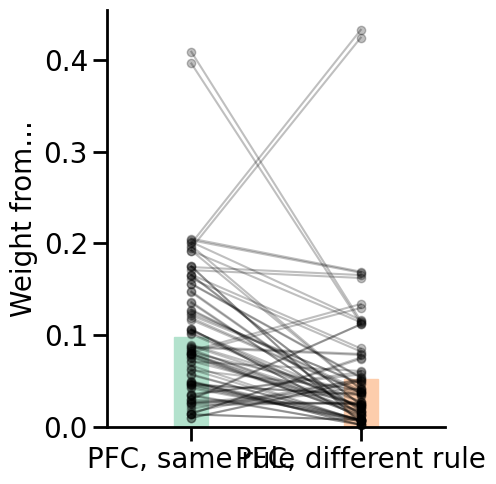

student t test, 1.9820827629773399, p=0.024522236754471016, n=88


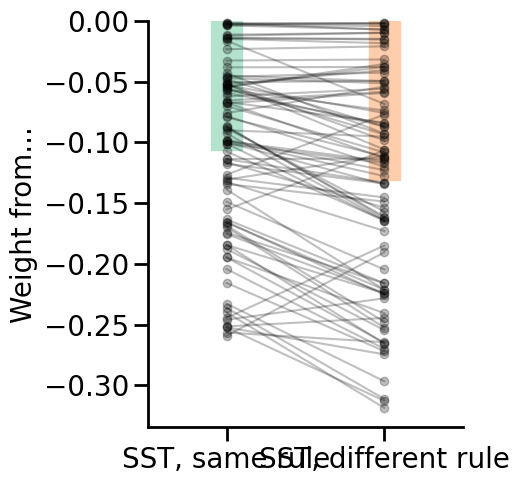

student t test, 3.330709650790767, p=0.0006388829151486244, n=44


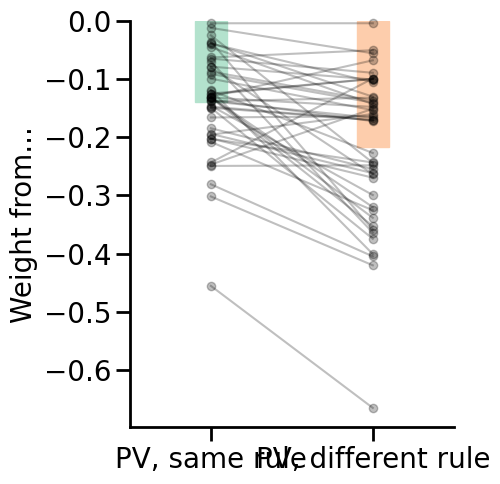

In [8]:
# plot each model separately

# source code for figure 4 of the paper
data_fig4 = {'top_down_weight_to_exc': {'from_same_rule': [], 'from_different_rule': []},
             'weight_from_sst_to_exc': {'from_same_rule': [], 'from_different_rule': []},
             'weight_from_pv_to_exc': {'from_same_rule': [], 'from_different_rule': []},
             'top_down_weight_to_vip': {'from_same_rule': [], 'from_different_rule': []},
             'top_down_weight_to_sst': {'from_same_rule': [], 'from_different_rule': []},
             'top_down_weight_to_pv': {'from_same_rule': [], 'from_different_rule': []}}


all_model_names = list(set([x['model'] for x in all_data_to_exc]))


for model_name in all_model_names:
    if model_name != 'success_2023-05-10-14-28-42_wcst_58_sparsity0':    # this is the model used in figure 4 of the paper
        continue
    hp = [x['hp'] for x in all_data_to_exc if x['model']==model_name][0]    
    
    
    
    w_pfc_same_rule_this_model = [x['w_pfc_same_rule_soma'] for x in all_data_to_exc if x['model']==model_name]
    w_pfc_diff_rule_this_model = [x['w_pfc_diff_rule_soma'] for x in all_data_to_exc if x['model']==model_name]
    w_smsst_same_rule_this_model = [x['w_smsst_same_rule_soma'] for x in all_data_to_exc if x['model']==model_name]
    w_smsst_diff_rule_this_model = [x['w_smsst_diff_rule_soma'] for x in all_data_to_exc if x['model']==model_name]
    w_smpv_same_rule_this_model = list(set([x['w_smpv_same_rule_soma'] for x in all_data_to_exc if x['model']==model_name]))    # the data for PV was written twice 
    w_smpv_diff_rule_this_model = list(set([x['w_smpv_diff_rule_soma'] for x in all_data_to_exc if x['model']==model_name]))

    data_fig4['top_down_weight_to_exc']['from_same_rule'] = w_pfc_same_rule_this_model
    data_fig4['top_down_weight_to_exc']['from_different_rule'] = w_pfc_diff_rule_this_model
    data_fig4['weight_from_sst_to_exc']['from_same_rule'] = w_smsst_same_rule_this_model
    data_fig4['weight_from_sst_to_exc']['from_different_rule'] = w_smsst_diff_rule_this_model
    data_fig4['weight_from_pv_to_exc']['from_same_rule'] = w_smpv_same_rule_this_model
    data_fig4['weight_from_pv_to_exc']['from_different_rule'] = w_smpv_same_rule_this_model
    
    # line plot
    for source in ['PFC', 'SST', 'PV']:
        fig, ax = plt.subplots(1, 1, figsize=[5, 5])
        fig.patch.set_facecolor('white')
        ax.set_xlim([-0.5, 1.5])
        ax.set_xlim([-0.5, 1.5])
        if source == 'PFC':
            data_same = w_pfc_same_rule_this_model
            data_different = w_pfc_diff_rule_this_model
        elif source == 'SST':
            data_same = w_smsst_same_rule_this_model
            data_different = w_smsst_diff_rule_this_model
        elif source == 'PV':
            data_same = w_smpv_same_rule_this_model
            data_different = w_smpv_diff_rule_this_model
        ax.plot([0, 1], [data_same, data_different], marker='o', color='k', alpha=0.25, clip_on=False)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['{}, same rule'.format(source), '{}, different rule'.format(source)], rotation=0)
        ax.set_ylabel('Weight from...', fontsize=20)
        
        
        # bar plot
        y = [data_same, data_different]
        ax.bar([0, 1], height=[np.mean(yi) for yi in y],
                       # capsize=12, # error bar cap width in points
                       width=0.2,    # bar width
                       color=colors,
                       edgecolor=colors
                      )
        if np.sum(y)!=0:     # no PFC->Edend connection
            ttest = stats.ttest_ind(y[0], y[1], alternative='greater')
            print('student t test, {}, p={}, n={}'.format(ttest[0], ttest[1], len(y[0])))
            
        make_pretty_axes(ax)
                
        fig.tight_layout()
        plt.show()

        # fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/top_down_conn_bias_{}_toSMexc_example.pdf'.format(source))

# Supplementary Figure 8a, d, f, g, j, l - across all models

subtractive pfc
student t test 24.538665445480135, p=1.6027807893233061e-124, n=2060


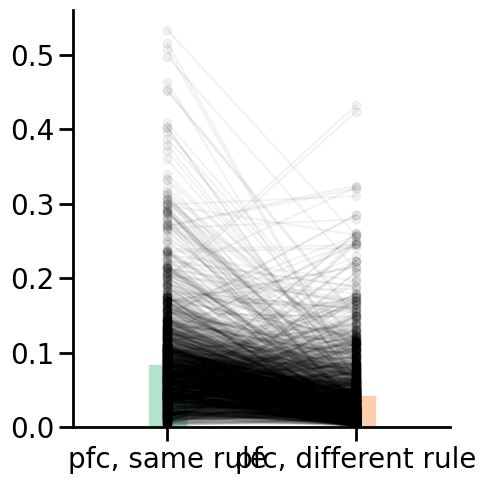

subtractive smsst
student t test 12.818135655324598, p=3.2662044004110474e-37, n=2060


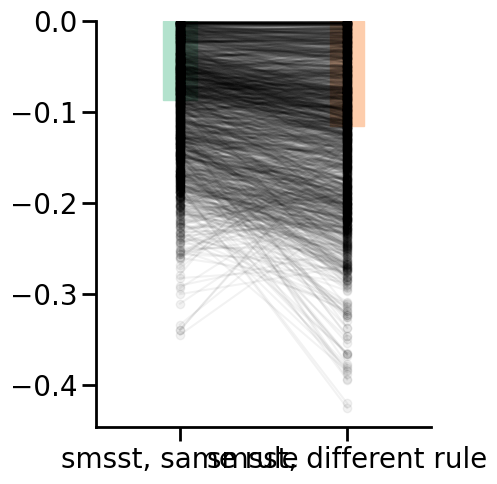

subtractive smpv
student t test 12.390762632106727, p=2.3267983400859073e-34, n=1030


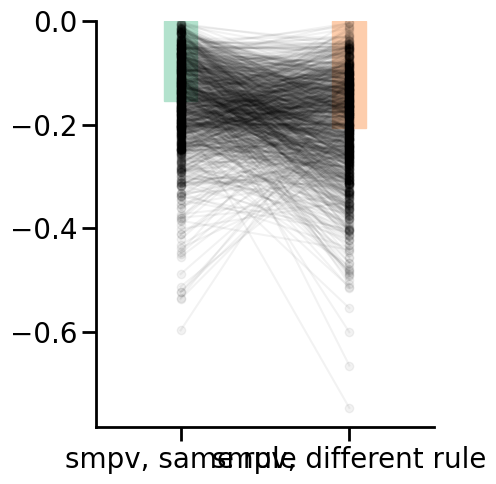

divisive_2 pfc
student t test 44.73747066616674, p=0.0, n=2524


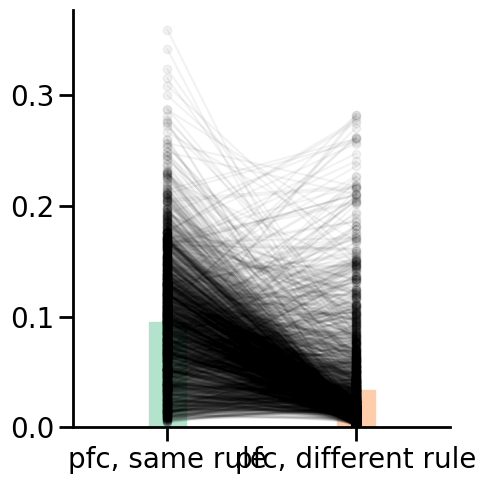

divisive_2 smsst
student t test 35.811446133335686, p=9.051265346844822e-251, n=2524


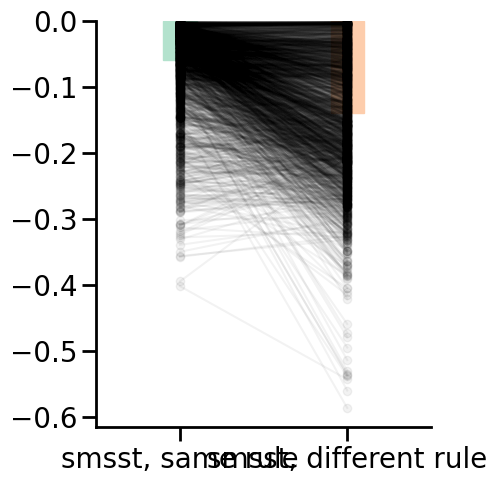

divisive_2 smpv
student t test 8.238776345255236, p=1.3805761704581324e-16, n=1262


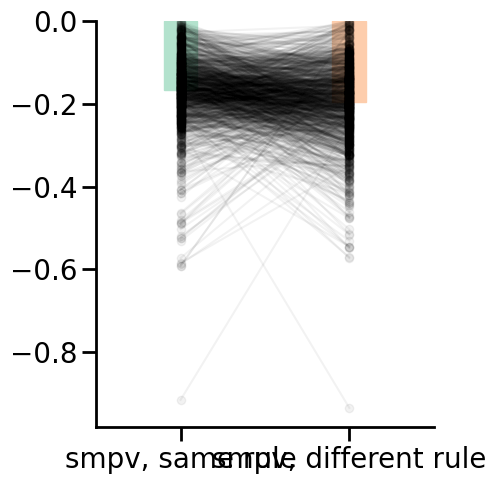

In [13]:
data_suppfig8 = {'subtractive': {}, 'divisive_2': {}}
for key in data_suppfig8.keys():
    data_suppfig8[key] = {'weight_from_pfc_to_exc': {'from_same_rule': [], 'from_different_rule': []},
                         'weight_from_smsst_to_exc': {'from_same_rule': [], 'from_different_rule': []},
                         'weight_from_smpv_to_exc': {'from_same_rule': [], 'from_different_rule': []},
                         'top_down_weight_to_vip': {'from_same_rule': [], 'from_different_rule': []},
                         'top_down_weight_to_sst': {'from_same_rule': [], 'from_different_rule': []},
                         'top_down_weight_to_pv': {'from_same_rule': [], 'from_different_rule': []}}
    
for dend_nonlinear in ['subtractive', 'divisive_2']:
    for source in ['pfc', 'smsst', 'smpv']:
        print(dend_nonlinear, source)
        fig, ax = plt.subplots(1, 1, figsize=[5, 5])
        fig.patch.set_facecolor('white')
        ax.set_xlim([-0.5, 1.5])
        ax.set_xlim([-0.5, 1.5])
        
        w_same = [x['w_{}_same_rule_soma'.format(source)] for x in all_data_to_exc if x['hp']['dend_nonlinearity'] == dend_nonlinear]
        w_diff = [x['w_{}_diff_rule_soma'.format(source)] for x in all_data_to_exc if x['hp']['dend_nonlinearity'] == dend_nonlinear]
        if source == 'smpv':    # data was included twice for PV neurons
            w_same = list(set(w_same))
            w_diff = list(set(w_diff))
        ax.plot([0, 1], [w_same, w_diff], marker='o', color='k', alpha=0.05)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['{}, same rule'.format(source), '{}, different rule'.format(source)], rotation=0)
        ax.set_ylabel('Weight from...', fontsize=20)
        
        # plot the means
        y = [w_same, w_diff]
        ax.bar([0, 1], height=[np.mean(yi) for yi in y],
                   width=0.2,    # bar width
                   color=colors,
                   edgecolor=colors
                  )
        ax.set_ylabel('')
        
        if np.sum(y)!=0:
            ttest = stats.ttest_ind(y[0], y[1], alternative='greater')
            print('student t test {}, p={}, n={}'.format(ttest[0], ttest[1], len(y[0])))

        make_pretty_axes(ax)    
        fig.tight_layout()
        plt.show()
        # fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/top_down_conn_bias_{}_toSMexc_allNetworks_{}.pdf'.format(source, dend_nonlinear))

        # source data
        # data_suppfig8[dend_nonlinear]['weight_from_{}_to_exc'.format(source)]['from_same_rule'] = w_same_rule_all_soma
        # data_suppfig8[dend_nonlinear]['weight_from_{}_to_exc'.format(source)]['from_different_rule'] = w_diff_rule_all_soma

# Figure 4b, c, e - example model

In [17]:
with open('/home/yl4317/Documents/two_module_rnn/processed_data/conn_bias_pfc_to_inh.pickle', 'rb') as handle:
    all_data_frompfc = pickle.load(handle)

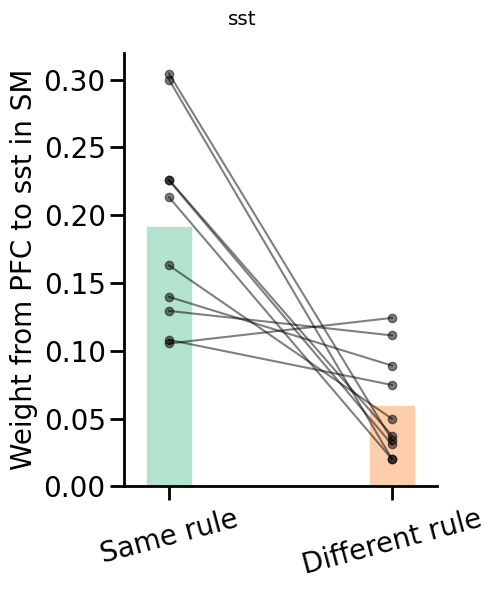

student t test, 5.031339122491586, p=4.3378681714891294e-05, n=10


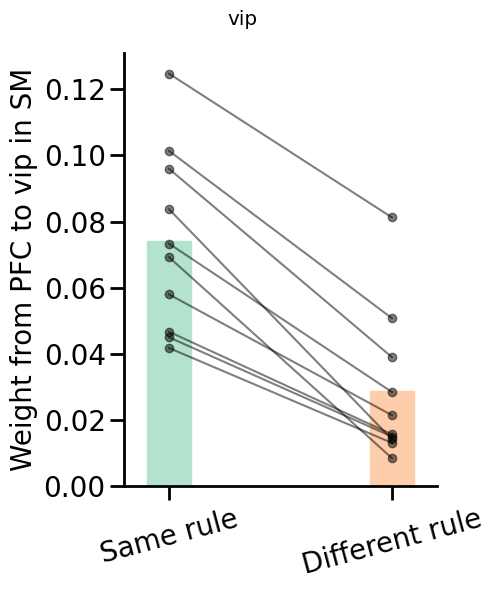

student t test, 4.014411693609804, p=0.0004066511498813514, n=10


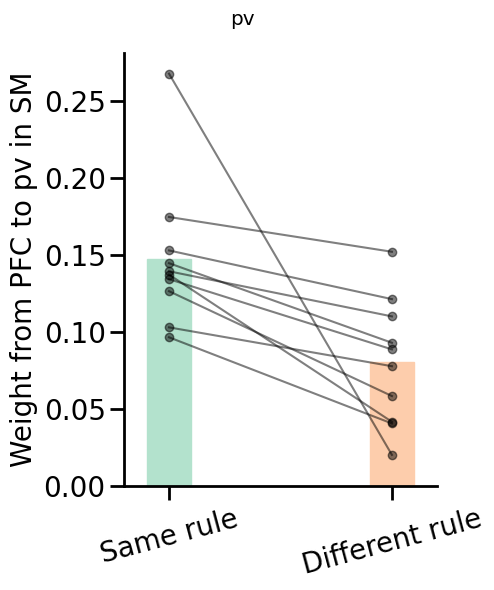

student t test, 3.3790727409997285, p=0.0016714300330545762, n=10


In [55]:
for x in all_data_frompfc:
    for target in ['pv', 'sst', 'vip']:
        if (target == 'pv' and x['name'] != 'success_2023-05-10-14-28-42_wcst_10_sparsity0') or ((target == 'sst' or target == 'vip') and x['name'] != 'success_2023-05-10-14-28-42_wcst_106_sparsity0'):    # the data in figure 4b is taken from one example model, the data in figure 4c, e is taken from another one
            continue
        y = [x['w_same_rule_{}'.format(target)], x['w_diff_rule_{}'.format(target)]]
        if np.array(y).size==0:
            print('size of y is 0, pass')
            continue
        if len(y[0])!=10 or len(y[1])!=10:
            continue
    
        # plot
        fig, ax = plt.subplots(1, 1, figsize=[5, 6])
        fig.patch.set_facecolor('white')
        fig.suptitle(target)
        ax.plot([0, 1], y, marker='o', color='k', alpha=0.5)
        ax.bar([0, 1],
                height=[np.mean(yi) for yi in y],
                width=0.2,    # bar width
                color=colors,
                edgecolor=colors)
        make_pretty_axes(ax)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Same rule', 'Different rule'], rotation=15)
        ax.set_ylabel('Weight from PFC to {} in SM'.format(target), fontsize=20)
        ax.set_xlim([-0.2, 1.2])
        fig.tight_layout()
        plt.show()

        # do statistical test
        ttest = stats.ttest_ind(y[0], y[1], alternative='greater')
        print('student t test, {}, p={}, n={}'.format(ttest[0], ttest[1], len(y[0])))

        # save figure
        # fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/top_down_conn_bias_PFC_toSM{}_example.pdf'.format(target))

        # source data
        # data_fig4['top_down_weight_to_{}'.format(target)]['from_same_rule'] = y[0]
        # data_fig4['top_down_weight_to_{}'.format(target)]['from_different_rule'] = y[1]



# Supplementary Figure 8b, c, e, h, i, k: aggregate across models

subtractive
student t test: 7.198201738459458, p=2.261316996126153e-12, n=250


/state/partition1/job-47081117/ipykernel_3700465/1748395314.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(ax.get_yticks(), 2))


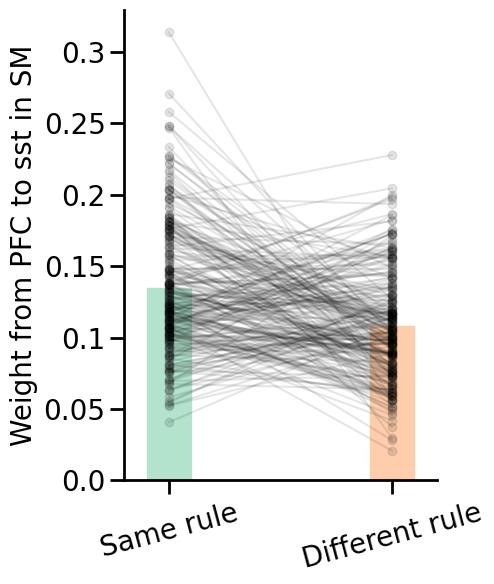

student t test: 2.342147126746652, p=0.02043666826592151, n=79


/state/partition1/job-47081117/ipykernel_3700465/1748395314.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(ax.get_yticks(), 2))


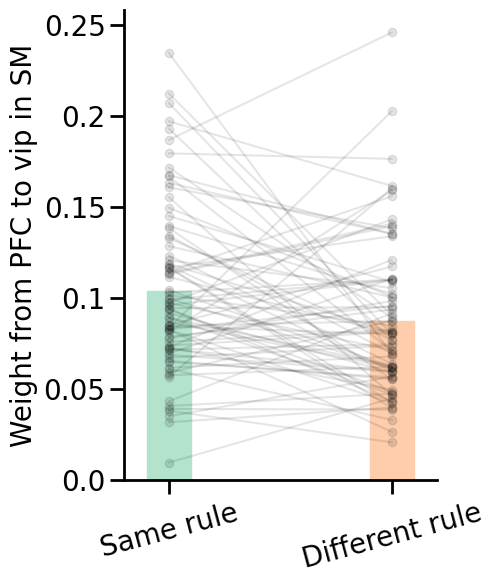

student t test: 10.423349456018801, p=3.818057201602386e-23, n=250


/state/partition1/job-47081117/ipykernel_3700465/1748395314.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(ax.get_yticks(), 2))


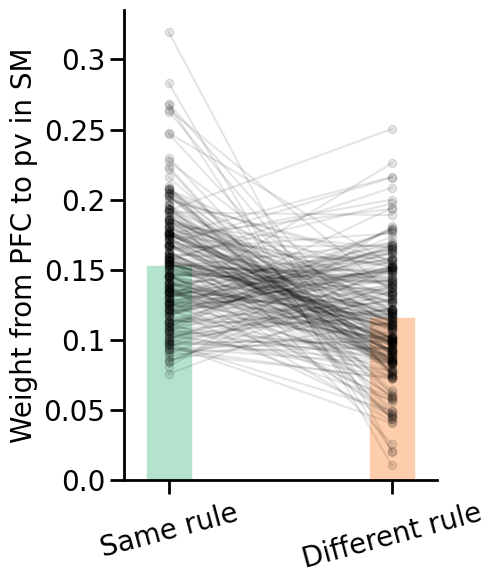

divisive_2
student t test: 22.607457558304827, p=3.026269283547666e-79, n=260


/state/partition1/job-47081117/ipykernel_3700465/1748395314.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(ax.get_yticks(), 2))


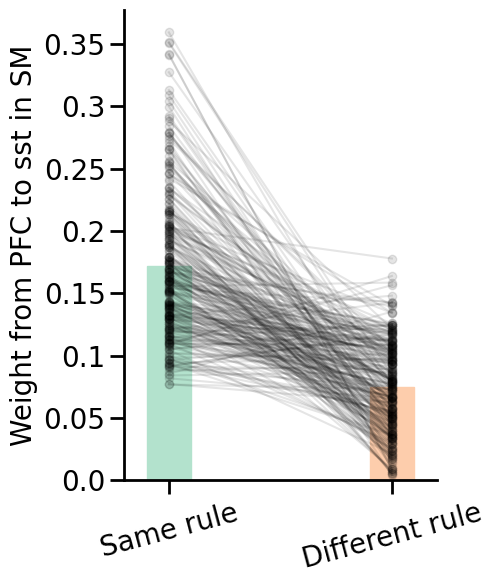

student t test: 1.6186772982142146, p=0.10658894736831506, n=148


/state/partition1/job-47081117/ipykernel_3700465/1748395314.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(ax.get_yticks(), 2))


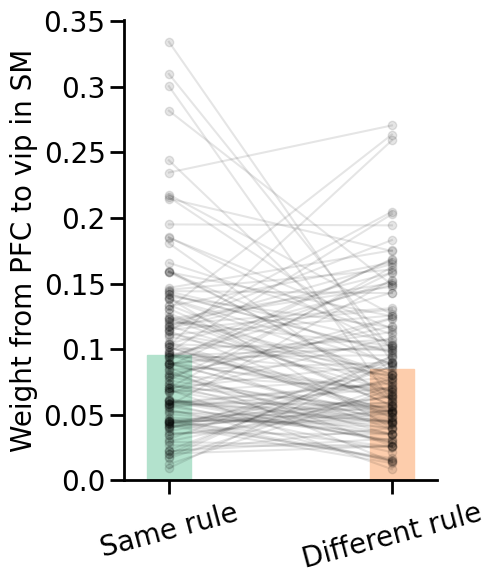

student t test: 6.971203907750713, p=9.608222980020366e-12, n=260


/state/partition1/job-47081117/ipykernel_3700465/1748395314.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(ax.get_yticks(), 2))


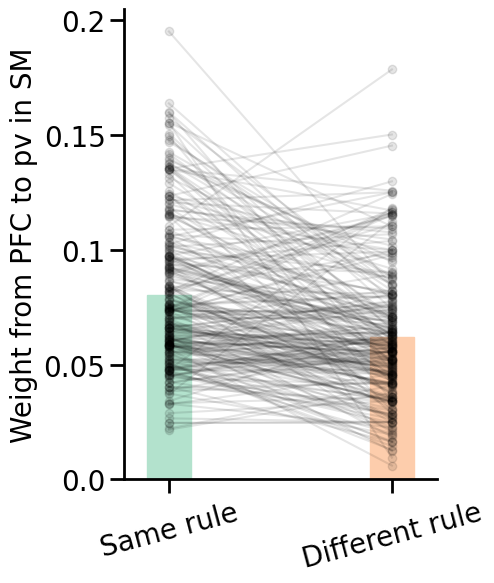

In [56]:
for dend_nonlinear in ['subtractive', 'divisive_2']:
    print(dend_nonlinear)
    for target in ['sst', 'vip', 'pv']:
        w_same_rule_all = []
        w_diff_rule_all = []  
        for x in all_data_frompfc:
            if x['hp']['dend_nonlinearity'] != dend_nonlinear:
                continue
            w_same_rule_all.extend(x['w_same_rule_{}'.format(target)])
            w_diff_rule_all.extend(x['w_diff_rule_{}'.format(target)])
        yy = [w_same_rule_all, w_diff_rule_all]
        
        fig, ax = plt.subplots(1, 1, figsize=[5, 6])
        fig.patch.set_facecolor('white')
        # do statistical test
        ttest = stats.ttest_ind(yy[0], yy[1])
        print('student t test: {}, p={}, n={}'.format(ttest[0], ttest[1], len(yy[0])))
            
        ax.plot([0, 1], yy, marker='o', color='k', alpha=0.1)
        ax.bar([0, 1],
                height=[np.mean(yi) for yi in yy],
                width=0.2,    # bar width
                color=colors,
                edgecolor=colors)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Same rule', 'Different rule'], rotation=15)
        ax.set_ylabel('Weight from PFC to {} in SM'.format(target), fontsize=20)
        ax.set_yticklabels(np.round(ax.get_yticks(), 2))
        ax.set_xlim([-0.2, 1.2])
        make_pretty_axes(ax)
        fig.tight_layout()
        plt.show()

        fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/top_down_conn_bias_PFC_toSM{}_allNets_{}.pdf'.format(target, dend_nonlinear))

        data_suppfig8[dend_nonlinear]['top_down_weight_to_{}'.format(target)]['from_same_rule'] = yy[0]
        data_suppfig8[dend_nonlinear]['top_down_weight_to_{}'.format(target)]['from_different_rule'] = yy[1]

In [58]:
# save to csv
pd.DataFrame.from_dict(data=data_fig4, orient='index').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/fig4.csv', header=False)
pd.DataFrame.from_dict(data=data_suppfig8['subtractive'], orient='index').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/suppfig8_subtractive.csv', header=False)
pd.DataFrame.from_dict(data=data_suppfig8['divisive_2'], orient='index').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/suppfig8_divisive_2.csv', header=False)